In [9]:
from dotenv import load_dotenv
load_dotenv()
import os

# MISTRAL EMB

In [10]:
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage

api_key = os.environ["MISTRAL_API_KEY"]
model = "open-mixtral-8x7b"

client = MistralClient(api_key=api_key)

chat_response = client.chat(
    model=model,
    messages=[ChatMessage(role="user", content="What is the best French cheese?")]
)

print(chat_response.choices[0].message.content)

I don't have personal experiences or opinions. However, I can share that France is famous for its diverse and high-quality cheeses. The "best" French cheese can vary greatly depending on personal preference. Here are a few notable ones:

1. Brie de Meaux: Known as the "King of Cheeses", it's a soft cheese with a white, edible rind. It's creamy and mildly flavored.

2. Camembert: This is another soft cheese, similar to Brie but often stronger in flavor. It's a classic French cheese from Normandy.

3. Comté: This is a hard cheese from the Jura Mountains. It's nutty and rich, often compared to Swiss cheeses but with a unique French flavor.

4. Roquefort: This is a blue cheese from the Roquefort-sur-Soulzon region. It's tangy, salty, and has a distinctive blue veining.

5. Reblochon: This is a soft, washed-rind cheese from the Savoie region. It's fruity and aromatic.

Remember, the "best" cheese is subjective and depends on your personal taste. It's worth trying different types to find you

In [11]:
from mistralai.client import MistralClient

client = MistralClient(api_key=api_key)

embeddings_batch_response = client.embeddings(
    model="mistral-embed",
    input=["Embed this sentence.", "As well as this one."],
)

In [15]:
len(embeddings_batch_response.data[0].embedding)

1024

In [28]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

def get_text_embedding(input):
    embeddings_batch_response = client.embeddings(
        model="mistral-embed",
        input=input
    )
    return embeddings_batch_response.data[0].embedding

In [30]:
sentences = [
    "Cars have significantly evolved over the decades, shifting from mere transportation tools to sophisticated vehicles equipped with advanced technologies like autonomous driving and eco-friendly engines.",
    "Autos haben sich im Laufe der Jahrzehnte erheblich weiterentwickelt, von einfachen Transportmitteln zu hochentwickelten Fahrzeugen mit Technologien wie autonomem Fahren und umweltfreundlichen Motoren.",
]
embeddings = [get_text_embedding(t) for t in sentences]

reference_sentence = "Over the years, cars have transformed from basic transport solutions to advanced, technology-equipped vehicles featuring autonomous driving and environmentally friendly engines."
reference_embedding = get_text_embedding(reference_sentence)

for t, e in zip(sentences, embeddings):
    distance = cosine_similarity([e], [reference_embedding])
    print(t, distance)

Cars have significantly evolved over the decades, shifting from mere transportation tools to sophisticated vehicles equipped with advanced technologies like autonomous driving and eco-friendly engines. [[0.96500469]]
Autos haben sich im Laufe der Jahrzehnte erheblich weiterentwickelt, von einfachen Transportmitteln zu hochentwickelten Fahrzeugen mit Technologien wie autonomem Fahren und umweltfreundlichen Motoren. [[0.88484854]]


In [31]:
sentences = [
    "Cars have significantly evolved over the decades, shifting from mere transportation tools to sophisticated vehicles equipped with advanced technologies like autonomous driving and eco-friendly engines.",
    "Autos haben sich im Laufe der Jahrzehnte erheblich weiterentwickelt, von einfachen Transportmitteln zu hochentwickelten Fahrzeugen mit Technologien wie autonomem Fahren und umweltfreundlichen Motoren.",
    "Cars have significantly evolved over the decades, shifting from mere transportation tools to sophisticated vehicles equipped with advanced technologies..."
]
embeddings = [get_text_embedding(t) for t in sentences]

In [32]:
cosine_similarity([embeddings[0]], [embeddings[1]]), cosine_similarity([embeddings[0]], [embeddings[2]])

(array([[0.89543375]]), array([[0.95042028]]))

In [35]:
import pandas as pd

df = pd.read_csv(
    "https://raw.githubusercontent.com/mistralai/cookbook/main/data/Symptom2Disease.csv",
    index_col=0,
)

def get_embeddings_by_chunks(data, chunk_size):
    chunks = [data[x : x + chunk_size] for x in range(0, len(data), chunk_size)]
    embeddings_response = [
        client.embeddings(model="mistral-embed", input=c) for c in chunks
    ]
    return [d.embedding for e in embeddings_response for d in e.data]

In [36]:
df["embeddings"] = get_embeddings_by_chunks(df["text"].tolist(), 50)

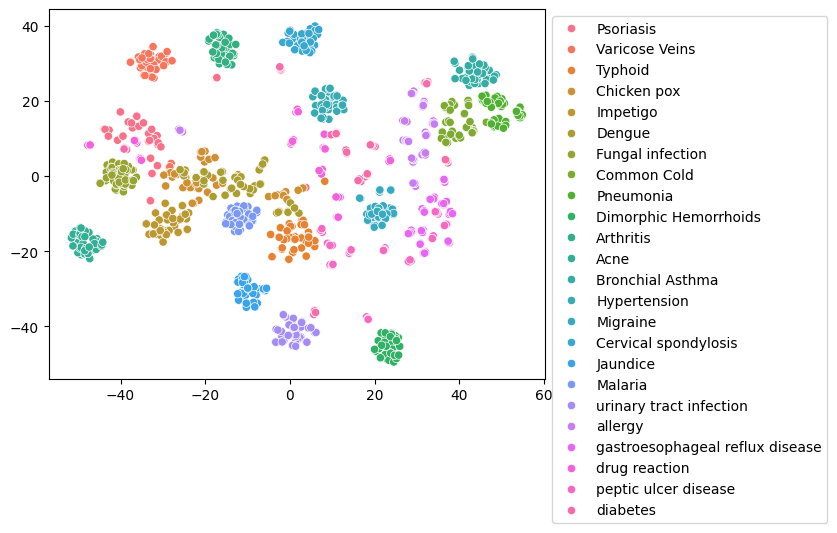

In [41]:
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE(n_components=2, random_state=0).fit_transform(np.array(df['embeddings'].to_list()))
ax = sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=np.array(df['label'].to_list()))
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Create a train / test split
train_x, test_x, train_y, test_y = train_test_split(
    df["embeddings"], df["label"], test_size=0.2
)

# Normalize features
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x.to_list())
test_x = scaler.transform(test_x.to_list())

# Train a classifier and compute the test accuracy
# For a real problem, C should be properly cross validated and the confusion matrix analyzed
clf = LogisticRegression(random_state=0, C=1.0, max_iter=500).fit(
    train_x, train_y.to_list()
)
# you can also try the sag algorithm:
# clf = LogisticRegression(random_state=0, C=1.0, max_iter=1000, solver='sag').fit(train_x, train_y)

print(f"Precision: {100*np.mean(clf.predict(test_x) == test_y.to_list()):.2f}%")

Precision: 99.17%


# OPENAI EMB

In [51]:
from openai import OpenAI
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

def oai_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [52]:
sentences = [
    "Cars have significantly evolved over the decades, shifting from mere transportation tools to sophisticated vehicles equipped with advanced technologies like autonomous driving and eco-friendly engines.",
    "Autos haben sich im Laufe der Jahrzehnte erheblich weiterentwickelt, von einfachen Transportmitteln zu hochentwickelten Fahrzeugen mit Technologien wie autonomem Fahren und umweltfreundlichen Motoren.",
    "Cars have significantly evolved over the decades, shifting from mere transportation tools to sophisticated vehicles equipped with advanced technologies..."
]
embeddings = [oai_embedding(t) for t in sentences]

In [53]:
cosine_similarity([embeddings[0]], [embeddings[1]]), cosine_similarity([embeddings[0]], [embeddings[2]])

(array([[0.68616948]]), array([[0.8924286]]))

In [54]:
pip install langchain streamlit streamlit_chat chromadb pypdf fastembed


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 17.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.21.2
    Uninstalling huggingface-hub-0.21.2:
      Successfully uninstalled huggingface-hub-0.21.2
Note: you may need to restart the kernel to use updated packages.
